In [1]:
from google.colab import files
uploaded = files.upload()

Saving features.txt to features.txt
Saving subject_test.txt to subject_test.txt
Saving subject_train.txt to subject_train.txt
Saving X_test.txt to X_test.txt
Saving X_train.txt to X_train.txt
Saving y_test.txt to y_test.txt
Saving y_train.txt to y_train.txt


In [2]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
features = list()
with open('features.txt') as file:
    features = [line.split()[1] for line in file.readlines()]

In [5]:
X_train = pd.read_csv('X_train.txt', delim_whitespace = True, header = None)
X_train.columns = features
X_train['subject'] = pd.read_csv('subject_train.txt', header = None, squeeze = True)

y_train = pd.read_csv('y_train.txt', names = ['Activity'], squeeze = True)
y_train_labels = y_train.map({1: 'walking', 
                              2:'upstairs',
                              3:'downstairs',
                              4:'sitting', 
                              5:'standing',
                              6:'laying'})

train = X_train
train['Activity'] = y_train
train['ActivityName'] = y_train_labels

X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis = 1)
y_train = train.ActivityName

print(X_train.shape, y_train.shape)
print(train.shape)

(7352, 561) (7352,)
(7352, 564)


In [6]:
X_test = pd.read_csv('X_test.txt', delim_whitespace = True, header = None)
X_test.columns = features
X_test['subject'] = pd.read_csv('subject_train.txt', header = None, squeeze = True)

y_test = pd.read_csv('y_test.txt', names = ['Activity'], squeeze = True)
y_test_labels = y_test.map({1: 'walking', 
                              2:'upstairs',
                              3:'downstairs',
                              4:'sitting', 
                              5:'standing',
                              6:'laying'})

test = X_test
test['Activity'] = y_test
test['ActivityName'] = y_test_labels

X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis = 1)
y_test = test.ActivityName

print(X_test.shape, y_test.shape) 
print(test.shape)

(2947, 561) (2947,)
(2947, 564)


In [7]:
labels = ['walking', 'upstairs', 'downstairs', 'sitting', 'standing', 'laying']

In [8]:
def plot_confusion_matrix(confusion_matrix, classes):
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis = 1)[:, np.newaxis]

    plt.imshow(confusion_matrix, interpolation = 'nearest', cmap = plt.cm.Blues)
    plt.title('Normalized confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)

    threshold = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], '.2f'), horizontalalignment = "center", color = "white" if confusion_matrix[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
from datetime import datetime

def perform_model(model, X_train, y_train, X_test, y_test, classes):
    results = dict()
    
    train_start_time = datetime.now()
    model.fit(X_train, y_train)
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('Training time: ', results['training_time'], '\n')
    
    test_start_time = datetime.now()
    y_predicted = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('Testing time: ', results['testing_time'], '\n')
    results['predicted'] = y_predicted
   
    accuracy = metrics.accuracy_score(y_true = y_test, y_pred = y_predicted)
    results['accuracy'] = accuracy
    print('Accuracy: ', accuracy, '\n')

    confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
    results['confusion_matrix'] = confusion_matrix

    plt.figure(figsize = (4, 4))
    plt.grid(b = False)
    plot_confusion_matrix(confusion_matrix, classes)
    plt.show()
    
    classification_report = metrics.classification_report(y_test, y_predicted)
    results['classification_report'] = classification_report
    
    results['model'] = model
    
    return results

Training time:  0:00:04.606801 

Testing time:  0:00:00.022524 

Accuracy:  0.9582626399728538 



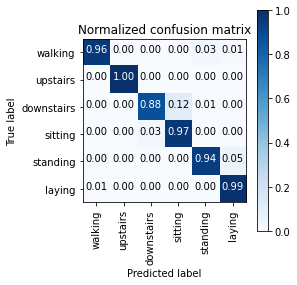

In [10]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.simplefilter(action = 'ignore', category = ConvergenceWarning)

parameters = {'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2', 'l1']}
logistic_regression = linear_model.LogisticRegression()
logistic_regression_grid = GridSearchCV(logistic_regression, parameters, cv = 3, verbose = 1, n_jobs = -1)
logistic_regression_grid_results =  perform_model(logistic_regression, X_train, y_train, X_test, y_test, labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training time:  0:01:47.314406 

Testing time:  0:00:00.021592 

Accuracy:  0.9667458432304038 



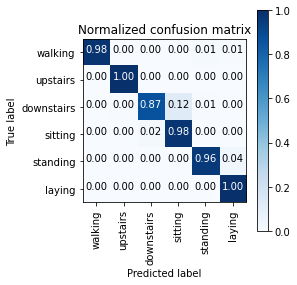

In [11]:
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
linear_svc = LinearSVC(tol = 0.00005)
linear_svc_grid = GridSearchCV(linear_svc, parameters, n_jobs = -1, verbose = 1)
linear_svc_grid_results = perform_model(linear_svc_grid, X_train, y_train, X_test, y_test, labels)

Training time:  0:08:33.742267 

Testing time:  0:00:01.571933 

Accuracy:  0.9623345775364778 



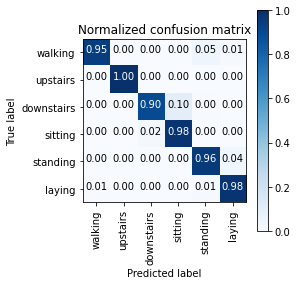

In [12]:
parameters = {'C':[2, 8, 16],'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm = SVC(kernel = 'rbf')
rbf_svm_grid = GridSearchCV(rbf_svm, param_grid = parameters, n_jobs = -1)
rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train, y_train, X_test, y_test, labels)

Training time:  0:00:29.261661 

Testing time:  0:00:00.011654 

Accuracy:  0.8659653885307091 



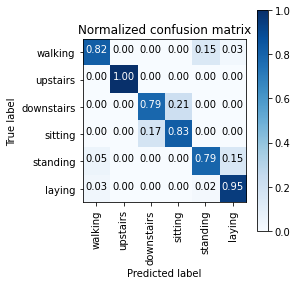

In [13]:
parameters = {'max_depth':np.arange(3, 10, 2)}
decision_tree = DecisionTreeClassifier()
decision_tree_grid = GridSearchCV(decision_tree, parameters, n_jobs = -1)
decision_tree_grid_results = perform_model(decision_tree_grid, X_train, y_train, X_test, y_test, labels)

Training time:  0:22:10.100767 

Testing time:  0:00:00.089496 

Accuracy:  0.9229725144214456 



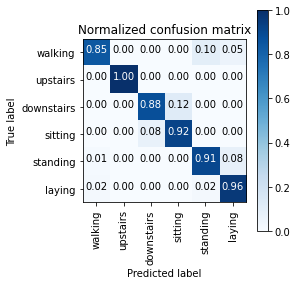

In [14]:
params = {'n_estimators': np.arange(10, 201, 20), 'max_depth': np.arange(3, 15, 2)}
random_forest = RandomForestClassifier()
random_forest_grid = GridSearchCV(random_forest, params, n_jobs = -1)
random_forest_grid_results = perform_model(random_forest_grid, X_train, y_train, X_test, y_test, labels)

In [ ]:
print('Accuracy: \n\n')
print('Logistic regression: ', logistic_regression_grid_results['accuracy']*100, '%')
print('Linear SVC: ', linear_svc_grid_results['accuracy']*100, '%')
print('RBF SVM Classifier: ', rbf_svm_grid_results['accuracy']*100, '%')
print('Decision Tree: ', decision_tree_grid_results['accuracy']*100, '%')
print('Random Forest: ', random_forest_grid_results['accuracy']*100, '%')


                     Accuracy     Error
                     ----------   --------
Logistic Regression : 95.83%       4.174%
Linear SVC          : 96.71%       3.291% 
rbf SVM classifier  : 96.23%      3.767% 
DecisionTree        : 86.46%      13.54% 
Random Forest       : 91.96%      8.042% 
